In [22]:
!pwd

/data19/ocr


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import webdataset as wds
import numpy as np
from itertools import islice
from collections import Counter
import glob
import os
import os.path

In [3]:
ds = wds.WebDataset("publaynet/publaynet-train-000000.tar").decode("rgb")

In [4]:
ids = []
for sample in islice(ds, 0, 200):
    for a in sample["json"]["annotations"]:
        ids.append(a["category_name"]+str(a["category_id"]))
Counter(ids)

Counter({'text1': 1378,
         'table4': 63,
         'title2': 373,
         'list3': 45,
         'figure5': 46})

In [5]:
src = iter(ds)

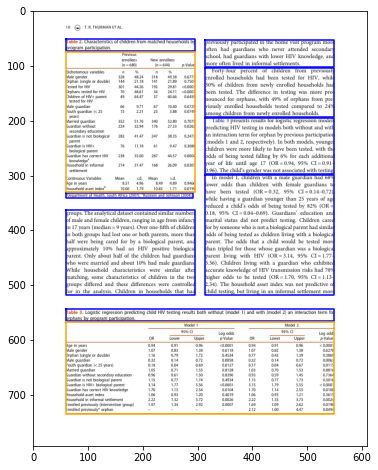

In [6]:
sample = next(src)
figsize(16, 8)
categories = ["black", "blue", "red", "green", "orange", "yellow", "cyan", "magenta"]
imshow(sample["png"])
for a in sample["json"]["annotations"]:
    x, y, w, h = a["bbox"]
    plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y], color=categories[a["category_id"]])

In [7]:
linspace(70, 0, 15)

array([70., 65., 60., 55., 50., 45., 40., 35., 30., 25., 20., 15., 10.,
        5.,  0.])

In [8]:
src = iter(ds)

In [9]:
sample = next(src)

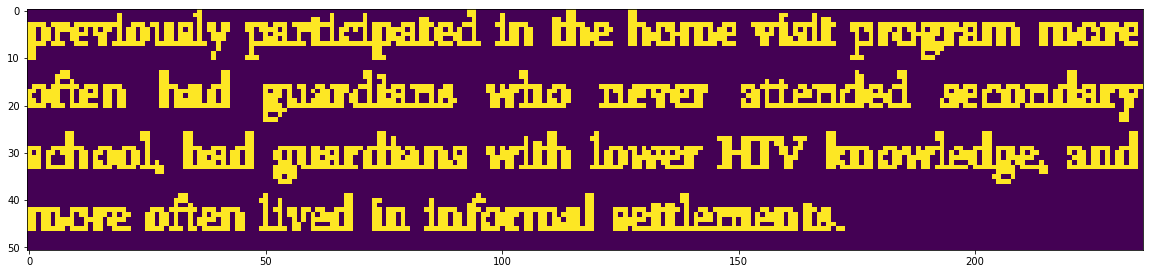

In [10]:
figsize(20, 10)
binary = (np.mean(sample["png"], 2) < 0.9)
a = sample["json"]["annotations"][0]
x0, y0, w, h = [int(x+0.5) for x in a["bbox"]]
x1, y1 = x0+w, y0+h
im = binary[y0:y1, x0:x1]
imshow(im)

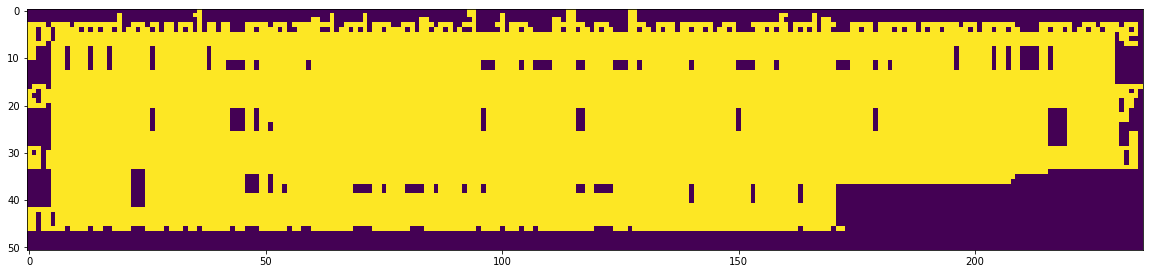

In [11]:
_stop = False
def vertical_runs(im, margin=5):
    im0 = im.copy()
    im0[:margin, :] = 0
    im0[-margin:, :] = 0
    im0[:, :margin] = 0
    im0[:, -margin:] = 0
    if _stop:
        clf(); imshow(im0); raise ValueError("_stop")
    marked = im0 * arange(im.shape[0])[:, newaxis]
    lo = np.amin(where(marked==0, 9999, marked), 0)
    hi = np.amax(marked, 0)
    output = np.zeros_like(marked)
    for x, (i, j) in enumerate(zip(lo, hi)):
        output[i:j, x] = 1
    return np.maximum(output, im)
def text_outline(im):
    return np.maximum(vertical_runs(im), vertical_runs(im.T).T)
imshow(text_outline(im))

In [12]:
import scipy.ndimage as ndi

def remove_rules(im, h=60, v=60):
    mask1 = ndi.maximum_filter(ndi.minimum_filter(im, (v, 0)), (v, 0))
    mask2 = ndi.maximum_filter(ndi.minimum_filter(im, (0, h)), (0, h))
    im = (im - mask1 - mask2).clip(0, 1)
    return im

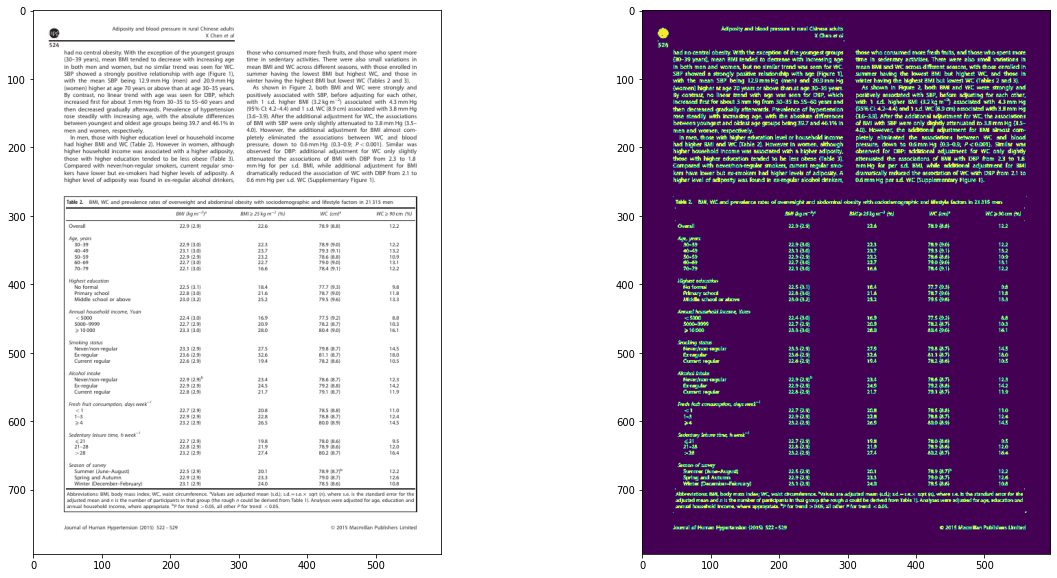

In [13]:
sample = next(src)
image = sample["png"]
binary = (np.mean(image, 2) < 0.9).astype(np.uint8)
binary = remove_rules(binary)
subplot(121); imshow(image)
subplot(122); imshow(binary)

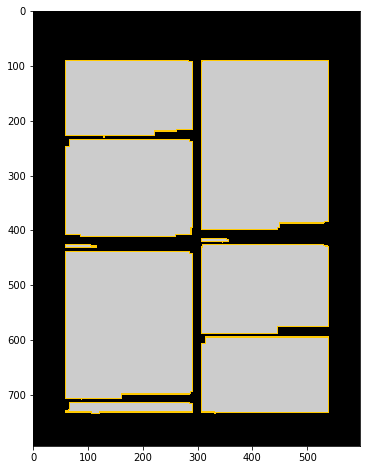

In [14]:
sample = next(src)

import scipy.ndimage as ndi

translate = np.array([0, 3, 3, 3, 1, 2], dtype=np.uint8)

def make_target(sample, threshold=0.9, text_r=(10, 10), r=(50, 50), dilate=0, margin=5, sigma=0.5):
    image = sample["png"]
    binary = (np.mean(image, 2) < threshold).astype(np.uint8)
    # remove rules and boxes for mask computations (requires perfectly axis aligned images)
    binary = remove_rules(binary)
    ih, iw = image.shape[:2]
    target = np.zeros((ih, iw), dtype=np.uint8)
    #overlap = np.zeros((h, w))
    for a in sample["json"]["annotations"]:
        value = a["category_id"]
        assert value > 0
        value = translate[value]
        x0, y0, w, h = [int(x+0.5) for x in a["bbox"]]
        x1, y1 = x0+w, y0+h
        isolated = np.zeros((ih, iw), dtype=np.uint8)
        isolated[y0:y1, x0:x1] = binary[y0:y1, x0:x1]
        if value == 3:
            # compute text outlines for text elements only
            isolated = ndi.maximum_filter(isolated, text_r)
            isolated = ndi.minimum_filter(isolated, text_r)
            isolated = text_outline(isolated)
        else:
            # for other elements, just use a large closing to compute a mask
            isolated = ndi.maximum_filter(isolated, r)
            isolated = ndi.minimum_filter(isolated, r)            
        if dilate > 0:
            isolated = ndi.maximum_filter(isolated, dilate)        
        if value == 3:
            # for text element (class 3), generate an outline and a central marker
            # this helps with text segmentation of nearby blocks
            target = np.maximum(3*isolated, target)
            isolated = ndi.minimum_filter(isolated, margin)
            target = np.maximum(4*isolated, target)
        else:
            target = np.where(isolated, value, target)
    assert np.amin(target) == 0
    assert np.amax(target) <= 4
    return target.astype(np.uint8)
 
figsize(16, 8)
#imshow(make_target(sample)[200:1200, 200:1200], vmin=0, vmax=4, cmap="nipy_spectral", interpolation="nearest")
imshow(make_target(sample), vmin=0, vmax=4, cmap="nipy_spectral", interpolation="nearest")

In [15]:
import re

def make_targets(shard, n=999999999):
    output = "publaynet-seg/" + os.path.basename(shard)
    output = re.sub(".tar$", "-mseg2.tar", output)
    print(shard, output)
    sink = wds.TarWriter(output+".temp")
    ds = wds.WebDataset(shard).decode("rgb")
    for sample in islice(ds, 0, n):
        global last_sample
        target = make_target(sample)
        sample["target.png"] = target
        last_sample = sample
        sink.write(sample)
    sink.close()
    if os.path.exists(output):
        os.unlink(output)
    os.rename(output+".temp", output)
    return output

In [16]:
shards = sorted(glob.glob("publaynet/publaynet-train-*.tar")) + sorted(glob.glob("publaynet/publaynet-val-*.tar"))

In [17]:
make_targets("publaynet/publaynet-train-000000.tar", n=5)
!rm publaynet-seg/publaynet-train-000000-mseg2.tar

publaynet/publaynet-train-000000.tar publaynet-seg/publaynet-train-000000-mseg2.tar
rm: cannot remove 'publaynet-seg/publaynet-train-000000-mseg2.tar': No such file or directory


dtype('uint8')

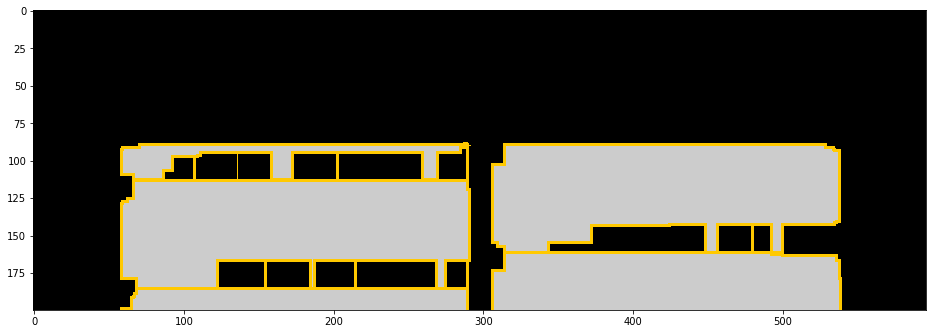

In [18]:
imshow(last_sample["target.png"][:200], vmin=0, vmax=4, cmap="nipy_spectral", interpolation="nearest")
last_sample["target.png"].dtype

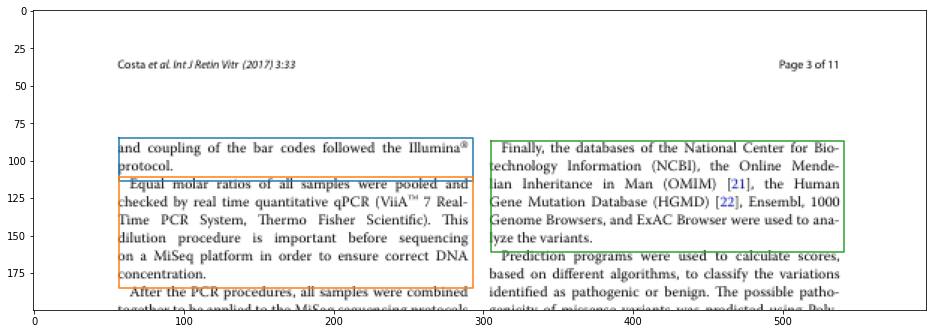

In [19]:
imshow(last_sample["png"][:200])
for a in last_sample["json"]["annotations"]:
    x, y, w, h = a["bbox"]
    if y+h > 200:
        continue
    plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y])

In [20]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=8, n_workers=1)
client

/home/tmb/.local/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38479 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:45505 Dashboard: http://127.0.0.1:38479/status,Cluster Workers: 1 Cores: 8 Memory: 33.58 GB


In [21]:
from dask.delayed import delayed
result = delayed([delayed(make_targets)(shard) for shard in shards])
result.compute()

['publaynet-seg/publaynet-train-000000-mseg2.tar',
 'publaynet-seg/publaynet-train-000001-mseg2.tar',
 'publaynet-seg/publaynet-train-000002-mseg2.tar',
 'publaynet-seg/publaynet-train-000003-mseg2.tar',
 'publaynet-seg/publaynet-train-000004-mseg2.tar',
 'publaynet-seg/publaynet-train-000005-mseg2.tar',
 'publaynet-seg/publaynet-train-000006-mseg2.tar',
 'publaynet-seg/publaynet-train-000007-mseg2.tar',
 'publaynet-seg/publaynet-train-000008-mseg2.tar',
 'publaynet-seg/publaynet-train-000009-mseg2.tar',
 'publaynet-seg/publaynet-train-000010-mseg2.tar',
 'publaynet-seg/publaynet-train-000011-mseg2.tar',
 'publaynet-seg/publaynet-train-000012-mseg2.tar',
 'publaynet-seg/publaynet-train-000013-mseg2.tar',
 'publaynet-seg/publaynet-train-000014-mseg2.tar',
 'publaynet-seg/publaynet-train-000015-mseg2.tar',
 'publaynet-seg/publaynet-train-000016-mseg2.tar',
 'publaynet-seg/publaynet-train-000017-mseg2.tar',
 'publaynet-seg/publaynet-train-000018-mseg2.tar',
 'publaynet-seg/publaynet-train